# 02 - Rule Coverage Analysis

Stage 2: apply regex rules to the preprocessed dataset and analyze
coverage, precision proxies, and matched spans.

In [29]:
import sys
sys.path.insert(0, '../../nlp_pipeline')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data_ingest import ingest
from src.preprocess import preprocess_dataframe
from src.rule_miner import RuleMiner

In [30]:
DATA_PATH = 'comments_merged.json'

df = ingest(DATA_PATH)
df = preprocess_dataframe(df)
print(f"Preprocessed {len(df)} comments")

[2026-02-24 22:22:46] src.data_ingest INFO: Ingesting comments_merged.json  (format=json)
[2026-02-24 22:22:48] src.data_ingest INFO: Loaded JSON  rows=84816
[2026-02-24 22:22:49] src.data_ingest INFO: Applying field aliases: {'cid': 'comment_id', 'votes': 'like_count', 'time_parsed': 'published_at'}
[2026-02-24 22:22:49] src.data_ingest INFO: Optional column 'video_id' not present; filling with None.
[2026-02-24 22:22:49] src.data_ingest INFO: Optional column 'language' not present; filling with None.
[2026-02-24 22:22:49] src.data_ingest INFO: 6207 rows contain emoji-only text.
[2026-02-24 22:22:51] src.data_ingest INFO: Schema validation complete.  84816 valid rows retained.
[2026-02-24 22:22:51] src.data_ingest INFO: Profiling complete: 84816 rows, 0 nulls in text, 0 duplicates.
[2026-02-24 22:22:51] src.data_ingest INFO: Ingestion complete: 84816 rows ingested from comments_merged.json.


Preprocessed 84816 comments


## Apply Rules

In [43]:
miner = RuleMiner()
df = miner.match_dataframe(df)
report = miner.coverage_report(df)
report

{'total_rows': 84816,
 'any_rule_hit': 189,
 'any_rule_hit_pct': 0.22,
 'per_label': {'AFFECTIVE_PREPACKAGING': {'hits': 5,
   'hit_pct': 0.01,
   'avg_confidence': 0.72},
  'COMMODIFICATION_MARKET_LOGIC': {'hits': 14,
   'hit_pct': 0.02,
   'avg_confidence': 0.7736},
  'FORMAL_RESISTANCE': {'hits': 100,
   'hit_pct': 0.12,
   'avg_confidence': 0.5072},
  'PSEUDO_INDIVIDUALIZATION': {'hits': 1,
   'hit_pct': 0.0,
   'avg_confidence': 0.75},
  'REGRESSIVE_LISTENING': {'hits': 8,
   'hit_pct': 0.01,
   'avg_confidence': 0.7188},
  'STANDARDIZATION': {'hits': 63, 'hit_pct': 0.07, 'avg_confidence': 0.6878}}}

## Coverage Bar Chart

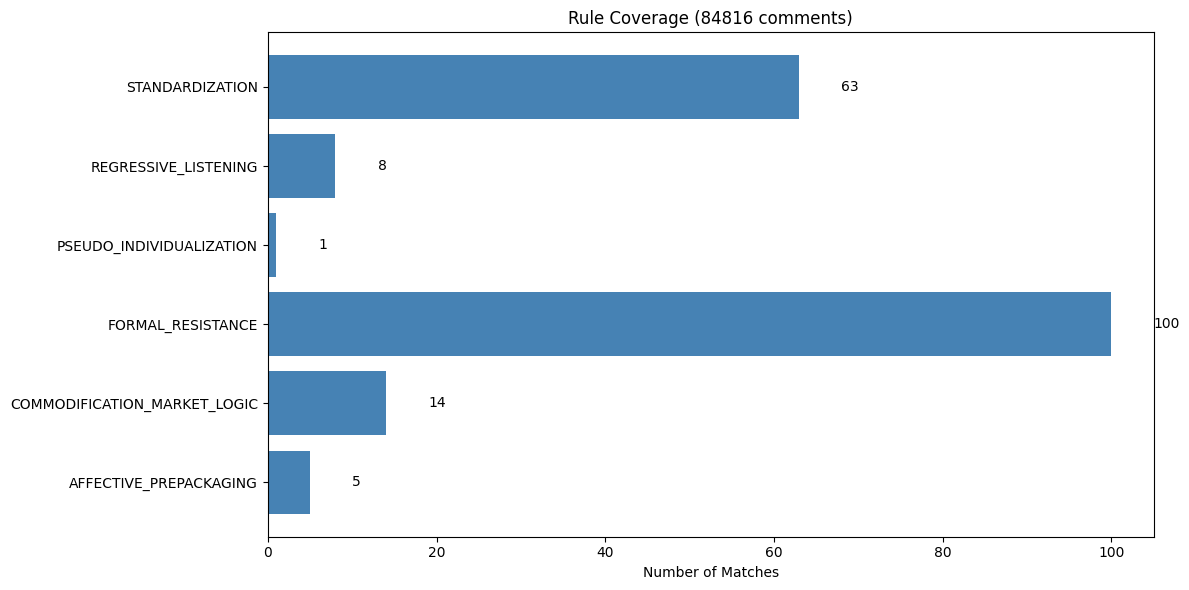

In [44]:
labels = list(report['per_label'].keys())
hits = [report['per_label'][l]['hits'] for l in labels]
pcts = [report['per_label'][l]['hit_pct'] for l in labels]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(labels, hits, color='steelblue')
for bar, hit in zip(bars, hits):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            str(hit), va='center')
ax.set_xlabel('Number of Matches')
ax.set_title(f'Rule Coverage ({report["total_rows"]} comments)')
plt.tight_layout()
plt.show()

## Confidence Distribution per Label

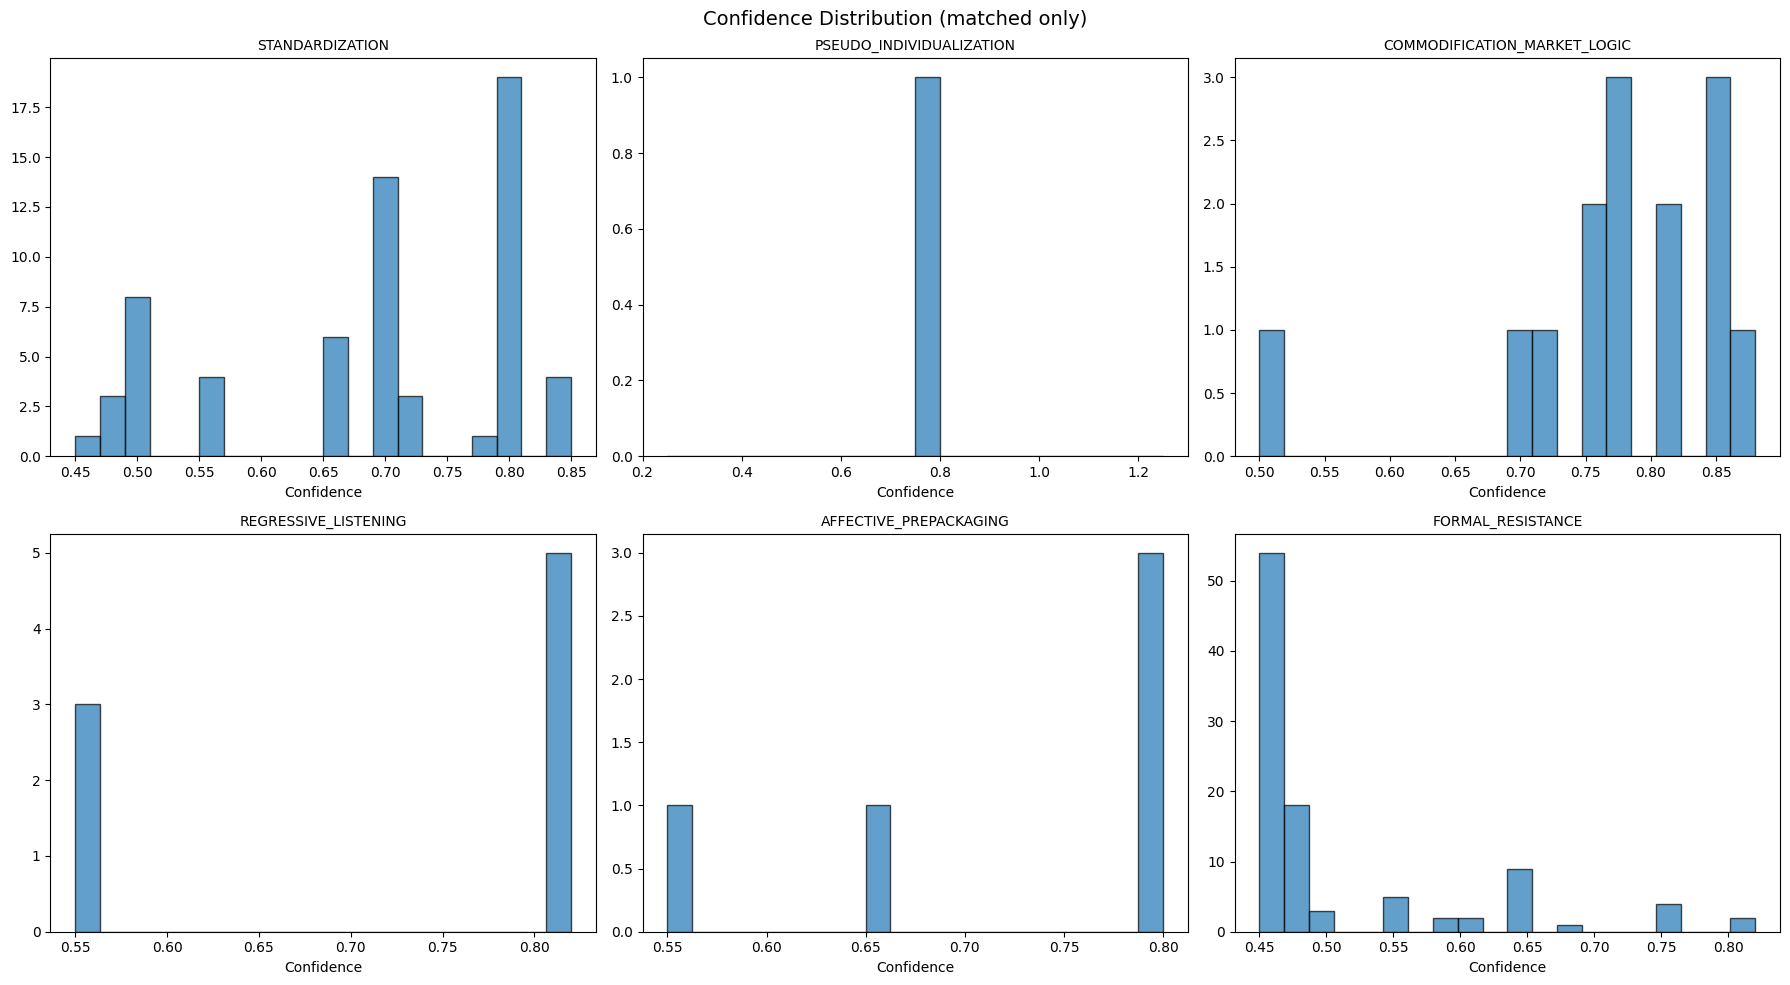

In [45]:
CRITIQUE_LABELS = [
    'STANDARDIZATION', 'PSEUDO_INDIVIDUALIZATION',
    'COMMODIFICATION_MARKET_LOGIC', 'REGRESSIVE_LISTENING',
    'AFFECTIVE_PREPACKAGING', 'FORMAL_RESISTANCE'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, lbl in zip(axes.flat, CRITIQUE_LABELS):
    col = f'rule_{lbl}_conf'
    matched = df[df[f'rule_{lbl}'] == True][col]
    if len(matched) > 0:
        ax.hist(matched, bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(lbl, fontsize=10)
    ax.set_xlabel('Confidence')
plt.suptitle('Confidence Distribution (matched only)', fontsize=14)
plt.tight_layout()
plt.show()

## Sample Matched Comments

In [46]:
for lbl in CRITIQUE_LABELS:
    matched = df[df[f'rule_{lbl}'] == True]
    if len(matched) > 0:
        print(f"\n--- {lbl} ({len(matched)} hits) ---")
        for _, row in matched.head(3).iterrows():
            print(f"  [{row[f'rule_{lbl}_conf']:.2f}] {row['clean_text'][:120]}")


--- STANDARDIZATION (63 hits) ---
  [0.50] Overrated song
  [0.80] this is literally a basic radio song, is so generic
  [0.65] I have never heard this before, but just now my new kitten I found out in the road.... she stepped on my noaa radio. She

--- PSEUDO_INDIVIDUALIZATION (1 hits) ---
  [0.75] literally are carbon copy of buttons

--- COMMODIFICATION_MARKET_LOGIC (14 hits) ---
  [0.78] If netflix allows it, this was a Netflix movie and yk how stingy they’re with money so i dont think they’ll make a seque
  [0.78] I can not agree more.... do it within 2026 and believe me it will be a good and successful cash grab as people want it! 
  [0.75] Funny thing is, K-pop is one of the most corporate music genres out there

--- REGRESSIVE_LISTENING (8 hits) ---
  [0.82] And Alicia Keys's background music.
  [0.82] Same. So basically he kept pushing until Ordinary was heard by enough of the ordinaries, and another ordinary overproces
  [0.82] its terrible, elevator music...

--- AFFECTIVE_

In [47]:
import json
import pandas as pd

# 1. Load the raw comments from the JSON file
with open('comments_merged.json', 'r', encoding='utf-8') as f:
    raw_comments = json.load(f)

# 2. Create a lookup dictionary for fast O(1) matching by comment content
# We use the text content as the key to quickly retrieve author, likes, replies, and song title
comments_lookup = {}
for comment in raw_comments:
    # Handle the field name whether it's 'text' or 'comment'
    text_content = comment.get('text', comment.get('comment', ''))
    
    comments_lookup[text_content] = {
        'author': comment.get('author', 'Unknown'),
        'song_title': comment.get('song_title', 'Unknown'),
        # Check for 'votes' or 'like_count'
        'likes': comment.get('votes', comment.get('like_count', 0)),
        'replies': comment.get('replies', 0)
    }

# 3. Define the labels to iterate over
CRITIQUE_LABELS = [
    'STANDARDIZATION', 'PSEUDO_INDIVIDUALIZATION',
    'COMMODIFICATION_MARKET_LOGIC', 'REGRESSIVE_LISTENING',
    'AFFECTIVE_PREPACKAGING', 'FORMAL_RESISTANCE'
]

results = []

# 4. Loop through the critique labels and matched comments
for lbl in CRITIQUE_LABELS:
    # Filter the dataframe for matched comments for this label
    matched = df[df[f'rule_{lbl}'] == True]
    
    for _, row in matched.iterrows():
        # Get the original text from the dataframe to use for matching
        df_text = row['text'] 
        
        # Look up the stored info from the JSON data using the comment text
        match_info = comments_lookup.get(df_text, {})
        
        author = match_info.get('author', 'Unknown')
        song_title = match_info.get('song_title', 'Unknown')
        likes = match_info.get('likes', 0)
        replies = match_info.get('replies', 0)
        
        results.append({
            'label': lbl,
            'song_title': song_title,
            'author': author,
            'likes': likes,
            'replies': replies,
            'text': df_text
        })

# 5. Convert the list of results to a DataFrame for easy viewing
matched_details_df = pd.DataFrame(results)
display(matched_details_df.head())


,label,song_title,author,likes,replies,text
0,STANDARDIZATION,Ordinary,@JemarcusTheLamb87,2,,Overrated song
1,STANDARDIZATION,Ordinary,@surferboypizza12,1,,"this is literally a basic radio song, is so ge..."
2,STANDARDIZATION,Ordinary,@redraif,0,,"I have never heard this before, but just now m..."
3,STANDARDIZATION,Ordinary,@wingsofabe,9,,"Same, and the label was right; the song is bor..."
4,STANDARDIZATION,Ordinary,@flylooper,1,,Overproduced...IMHO


In [48]:
import json
import pandas as pd

# 1. Load the raw comments from the JSON file
with open('comments_merged.json', 'r', encoding='utf-8') as f:
    raw_comments = json.load(f)

# 2. Create a lookup dictionary for fast O(1) matching by comment content
comments_lookup = {}
for comment in raw_comments:
    # Handle the field name whether it's 'text' or 'comment'
    text_content = comment.get('text', comment.get('comment', ''))
    
    comments_lookup[text_content] = {
        'author': comment.get('author', 'Unknown'),
        'song_title': comment.get('song_title', 'Unknown'),
        'artists': comment.get('artists', 'Unknown'),
        'time': comment.get('time', 'Unknown'),
        'likes': comment.get('votes', comment.get('like_count', 0)),
        'replies': comment.get('replies', 0)
    }

# 3. Define the labels to iterate over
CRITIQUE_LABELS = [
    'STANDARDIZATION', 'PSEUDO_INDIVIDUALIZATION',
    'COMMODIFICATION_MARKET_LOGIC', 'REGRESSIVE_LISTENING',
    'AFFECTIVE_PREPACKAGING', 'FORMAL_RESISTANCE'
]

# 4. Open a Markdown file to write the styled output
with open("matched_comments_detailed.md", "w", encoding="utf-8") as f:
    f.write("# Rule Coverage Analysis - Matched Comments\n\n")
    
    # Loop through the critique labels
    for lbl in CRITIQUE_LABELS:
        # Filter the dataframe for matched comments for this label
        matched = df[df[f'rule_{lbl}'] == True]
        
        if len(matched) > 0:
            f.write(f"## {lbl}\n")
            f.write(f"**Total Hits:** {len(matched)}\n\n")
            
            # Sort by confidence score (optional, but nice for presentation)
            matched = matched.sort_values(by=f'rule_{lbl}_conf', ascending=False)
            
            # Iterate through the matches
            for i, (_, row) in enumerate(matched.iterrows(), 1):
                df_text = row['text']
                clean_text = str(row['clean_text']).replace('\n', ' ')
                conf = row[f'rule_{lbl}_conf']
                
                # Look up the stored info from the JSON data using the comment text
                match_info = comments_lookup.get(df_text, {})
                
                author = match_info.get('author', 'Unknown')
                song_title = match_info.get('song_title', 'Unknown')
                artist = match_info.get('artists', 'Unknown')
                time_str = match_info.get('time', 'Unknown')
                
                # Clean up missing metrics
                likes = match_info.get('likes', 0)
                if pd.isna(likes) or str(likes).strip() == '': likes = 0
                    
                replies = match_info.get('replies', 0)
                if pd.isna(replies) or str(replies).strip() == '': replies = 0
                
                # Write the styled comment block
                f.write(f"### {i}. {author} (Confidence: {conf:.2f})\n\n")
                f.write(f"🎵 **Song:** {song_title} — {artist}\n\n")
                f.write(f"> {clean_text}\n\n")
                f.write(f"👍 **{likes}** Likes | 💬 **{replies}** Replies | 🕒 {time_str}\n\n")
                f.write("---\n\n")
            
            f.write("<br>\n\n") # Add some breathing room between categories

print("Successfully exported to 'matched_comments_detailed.md'!")


Successfully exported to 'matched_comments_detailed.md'!
